# Code to work with Visscher Chemistry Table

In [1]:
import numpy as np
from matplotlib.pylab import plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from scipy import signal
from scipy.special import wofz
import pandas as pd
import sys
import time
import pickle as pk
import json
#import numba
#from numba import jit, vectorize, guvectorize, float64, float32, complex64, complex128, int32,int64,cuda
import cmath
from timeit import default_timer as timer
#import psutil
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from scipy import interpolate
import bz2
from matplotlib.ticker import ScalarFormatter

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from matplotlib import interactive
interactive(True)

# Function to plot Visscher 1/T VS. Mole fraction for specified P 
**Input**: X,Y,x_lable,y_lable,output_name,output_path,data_labels, plot_label

In [2]:
def plot_XY(X,Y,x_lable,y_lable,output_name,output_path,data_labels, plot_label):
    fig=plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(ncols=1, nrows=1)
    ax11=plt.subplot(gs[0])
    plt.minorticks_on()
    #ax11.set_yscale('log')
    #ax11.set_xscale('log')
    ax11.set_xticks([2, 4, 6, 8, 8, 10, 12, 14])
    #ax11.set_yticks([1E-30, 1E-24, 1E-22, 1E-20])
    ax.tick_params(direction='in',axis='y',length=4,width=1.5,labelsize=12,which='major')
    ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(direction='in',axis='x',length=4,width=1.5, labelsize=12, which="major")
    ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")    #ax11.set_yscale('log')
    CB_color= ['#377eb8', '#ff7f00', '#4daf4a', '#a65628', '#984ea3', '#e41a1c', '#dede00', "#D35FB7"]
    for axis in [ax11.xaxis]:
        formatter = ScalarFormatter()
        formatter.set_scientific(False)
        axis.set_major_formatter(formatter)
    for i in range(len(data_labels)):
        ax11.plot(X,Y[data_labels[i]])
    ax11.set_ylabel(y_lable,fontsize=12)
    ax11.set_xlabel(x_lable,fontsize=12)
    ax11.text(3,-8.3,plot_label,fontsize=11,fontweight='bold')
    ax11.legend(data_labels,frameon=False,loc="upper right", ncol=1,fontsize=9,labelspacing=.1)
    ax11.set_xlim((1.8,14.8))
    ax11.set_ylim((-12,-7.9))
    plt.subplots_adjust(left=.22, bottom=.18, right=.99, top=.97, wspace=None, hspace=None)
    fig.savefig(output_path+output_name+".pdf")
    plt.show()

In [3]:
from bokeh.plotting import figure, output_file, show
def plot_XY_interactive(X,Y,x_lable, y_lable,legend):
    # create a new plot with a title and axis labels
    p = figure(title="simple line example", x_axis_label=x_lable, y_axis_label=y_lable)
    p.line(x, y, legend_label=legend, line_width=2)
    show(p)


# Read Visscher chem table


# Plot  Brown-Dwarf Evolutionary models
Reference: Marley, Saumon et. al (1996), Atomospheric evolutionary models 
link:https://ui.adsabs.harvard.edu/abs/1996Sci...272.1919M/abstract  

Equations:\
Eq 1: Mass vs. T:    $M = 36 M_J (\frac{g}{1000})^{0.64}  (\frac{T_{eff}}{1000})^{0.23}$ \
Eq 2: Age vs. T:     $t = 1.1 Gyr (\frac{g}{1000})^{1.7}  (\frac{T_{eff}}{1000})^{-2.8}$ \
Eq 3: Radius vs. T:  $R = 67200 km  (\frac{g}{1000})^{-0.18}  (\frac{T_{eff}}{1000})^{0.11}$ \
From these eqs., we can derive age vs. T and have the mass instead of surface gravity:\

In [4]:
M_J=1.8981E27 #kg, Jupiter mass
def Marley96_Equations (equation,X1, X2):
    result=np.zeros((len(X2),len(X1)))
    # Equation 1 (Mass vs. T):   mass = (g,Teff); results in Jupiter-mass
    if equation == "M_g_T":
        g=X1;T=X2
        for i in range (len(g)):
            for j in range (len(T)):
                result[j,i] = (36)  *  ((g[i]/1000)**(0.64))   *  ((T[j]/1000)**(0.23))
    # Equation 2 (Age vs. T):   t = (g,Teff); results in Gyr
    if equation == "t_g_T":
        g=X1;T=X2
        for i in range (len(g)):
            for j in range (len(T)):
                result[j,i] = (1.1)  *  ((g[i]/1000.)**(1.7))   *  ((T[j]/1000.)**(-2.8))
    # Equation 3 (Radius vs. T):   R = (g,Teff); results in km
    if equation == "R_g_T":
        g=X1;T=X2
        for i in range (len(g)):
            for j in range (len(T)):
                result[j,i] = (67200)  *  ((g[i]/1000)**(-0.18))   *  ((T[j]/1000)**(0.11))
    # Equation 4 (Age vs. T):   t = (Mass,Teff); results in Gyr
    if equation == "t_M_T":
        M=X1;T=X2
        for i in range (len(M)):
            for j in range (len(T)):
                XX1=1.1*np.power((1/1000.0),1.7)*np.power((T[j]/1000.0),(-2.8))
                XX2=np.power((M[i]/(36)),2.65625E0)*np.power((T[j]/1000),-0.6109375E0)*np.power((1000),1.7E0)
                result[j,i] = XX1 * XX2
    # Equation 5 (Age vs. T):   M = (t,Teff); results in MJ
    if equation == "M_t_T":
        t=X1;T=X2
        g=(1.0/2.65625)
        for i in range (len(t)):
            for j in range (len(T)):
                XX1=t[i]*np.power(1.1,-1)*np.power((1/1000.0),-1.7)*np.power((T[j]/1000.0),(2.8))
                XX1=np.power(XX1,0.376E0)
                XX2=36.0*np.power((T[j]/1000),0.23)*np.power(1000,-0.64)
                result[j,i] = XX1 * XX2
    return (result)

# Eq 1: M (g, T):    $M = 36 M_J (\frac{g}{1000})^{0.64}  (\frac{T_{eff}}{1000})^{0.23}$

data (100, 100)


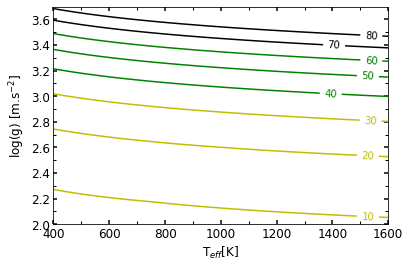

In [5]:
T=np.linspace(400,1600,100)    # T_eff [K]
M=np.linspace(20,80,100)        # in M_Jupiter
g=np.linspace(100,5000,100)    # surface gravity in [m.s^-1] equalent to log(g)=2-3.7
eq="M_g_T"
data=Marley96_Equations(eq,g,T);print("data",np.shape(data))
g, T = np.meshgrid(g, T)
fig, ax = plt.subplots()
CS = ax.contour(T, np.log10(g), data,levels=[10, 20, 30,40,50,60,70,80],colors=["y","y","y","g","g","g","k","k"])
ax.clabel(CS, inline=1, fontsize=10,fmt = '%2.0f') 
ax.set_xlabel("T$_{eff}$[K]",fontsize=12)
ax.set_ylabel("log(g) [m.s$^{-2}$]",fontsize=12)
ax.tick_params(direction='in',axis='y',length=4,width=1.5,labelsize=12,which='major')
ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction='in',axis='x',length=4,width=1.5, labelsize=12, which="major")
ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Eq 2: t (g,T):    $t = 1.1 Gyr (\frac{g}{1000})^{1.7}  (\frac{T_{eff}}{1000})^{-2.8}$

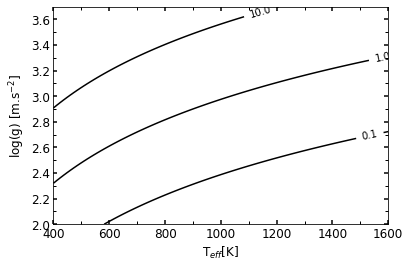

In [6]:
T=np.linspace(400,1600,100)  # T_eff [K]
M=np.linspace(20,80,10)    # in M_Jupiter
g=np.linspace(100,5000,3000)    # surface gravity in [m.s^-1] equalent to log(g)=2-3.7
eq="t_g_T"
data=Marley96_Equations(eq,g,T)#;print("data",np.shape(data),data)
g, T = np.meshgrid(g, T)
fig, ax = plt.subplots()
CS = ax.contour(T, np.log10(g), data,levels=[0.1,1,10],colors="k")
ax.clabel(CS, fontsize=10,fmt = '%2.1f')
ax.set_xlabel("T$_{eff}$[K]",fontsize=12)
ax.set_ylabel("log(g) [m.s$^{-2}$]",fontsize=12)
ax.tick_params(direction='in',axis='y',length=4,width=1.5,labelsize=12,which='major')
ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction='in',axis='x',length=4,width=1.5, labelsize=12, which="major")
ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Eq 3: R (g,T):  $R = 67200 km  (\frac{g}{1000})^{-0.18}  (\frac{T_{eff}}{1000})^{0.11}$ 


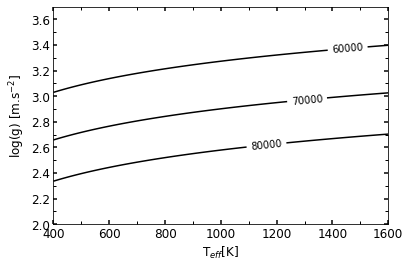

In [7]:
T=np.linspace(400,1600,100)  # T_eff [K]
M=np.linspace(20,80,10)    # in M_Jupiter
g=np.linspace(100,5000,300)    # surface gravity in [m.s^-1] equalent to log(g)=2-3.7
eq="R_g_T"
data=Marley96_Equations(eq,g,T)#;print("data",np.shape(data),data)
g, T = np.meshgrid(g, T)
fig, ax = plt.subplots()
CS = ax.contour(T, np.log10(g), data,levels=[60000,70000,80000],colors="k")
ax.clabel(CS, inline=1, fontsize=10,fmt = '%2.0f')
ax.set_xlabel("T$_{eff}$[K]",fontsize=12)
ax.set_ylabel("log(g) [m.s$^{-2}$]",fontsize=12)
ax.tick_params(direction='in',axis='y',length=4,width=1.5,labelsize=12,which='major')
ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction='in',axis='x',length=4,width=1.5, labelsize=12, which="major")
ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Eq 4: t (M,T):  $t = (1.1 Gyr) (\frac{1}{1000})^{1.7} (\frac{T_{eff}}{1000})^{-2.8} [(\frac{M}{36 M_J}) ({1000})^{0.64} (\frac{T_{eff}}{1000})^{-0.23}]^{1.7/0.64}$


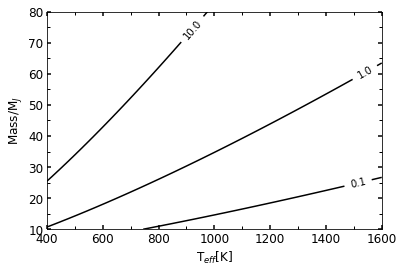

In [8]:
T=np.linspace(400,1600,100)    # T_eff [K]
M=np.linspace(10,80,100)        # in M_Jupiter
g=np.linspace(100,5000,300)    # surface gravity in [m.s^-1] equalent to log(g)=2-3.7
eq="t_M_T"
data=Marley96_Equations(eq,M,T)#;print("data",np.shape(data),data*1E9)
M, T = np.meshgrid(M, T)
fig, ax = plt.subplots()
CS = ax.contour(T, M, data,colors="k",levels=[0.1,1,10])
ax.clabel(CS, inline=1, fontsize=10,fmt = '%2.1f')
ax.set_xlabel("T$_{eff}$[K]",fontsize=12)
ax.set_ylabel("Mass/M$_J$",fontsize=12)
ax.tick_params(direction='in',axis='y',length=4,width=1.5,labelsize=12,which='major')
ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction='in',axis='x',length=4,width=1.5, labelsize=12, which="major")
ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Eq 5: M (t, T):     $M = (36 M_J) ({1000})^{-0.64} (\frac{T_{eff}}{1000})^{0.23}   [ (\frac{t}{1.1 Gyr}) (\frac{1}{1000})^{-1.7} (\frac{T_{eff}}{1000})^{2.8}]^{0.64/1.7}$


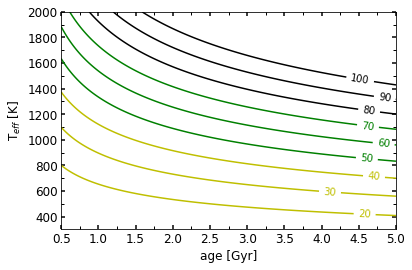

In [9]:
T=np.linspace(300,2000,100)    # T_eff [K]
M=np.linspace(20,100,10)        # in M_Jupiter
g=np.linspace(10**2.0,10**3.6,300)    # surface gravity in [m.s^-1] equalent to log(g)=2-3.7
t=np.linspace(0.5,5,300)    # age in Gyr
eq="M_t_T"
data=Marley96_Equations(eq,t,T)#;print("data",np.shape(data),data)
t, T = np.meshgrid(t, T)
fig, ax = plt.subplots()
CS = ax.contour(t,T, data,levels=[20,30,40,50,60,70,80,90,100],colors=["y","y","y","g","g","g","k","k","k"])
ax.clabel(CS, inline=1, fontsize=10,fmt = '%2.0f')
ax.set_xlabel("age [Gyr]",fontsize=12)#;ax.set_xlim((0.1,2))
ax.set_ylabel("T$_{eff}$ [K]",fontsize=12)
ax.tick_params(direction='in',axis='y',length=4,width=1.5,labelsize=12,which='major')
ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction='in',axis='x',length=4,width=1.5, labelsize=12, which="major")
ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
#ax.set_xticks([0.1,1,2]);

# Eq 6: g (M, T): $g=[ (\frac{M}{36M_J}) ({1000}^{0.64}) (\frac{T_{eff}}{1000})^{-0.23}]^{1/0.64}$

In [10]:
def Marley_g_M_T (M,T_eff):
    # in this equation, M is in Jupiter mass and T in K. results are in m.s^-2
    g = ( (M/36) * np.power(1000.0,0.64) * np.power((T_eff/1000),-0.23))**(1.0/0.64)
    return g
M=20;T=1000;print (Marley_g_M_T(M,T))
M=20;T=1500;print (Marley_g_M_T(M,T))
M=20;T=2000;print (Marley_g_M_T(M,T))
M=70;T=1000;print (Marley_g_M_T(M,T))
M=70;T=1500;print (Marley_g_M_T(M,T))
M=70;T=2000;print (Marley_g_M_T(M,T))
M=100;T=5000;print (Marley_g_M_T(M,T))

399.15053046302626
345.02766141998137
311.1387166745624
2826.4612128602434
2443.206830355919
2203.232733975347
2767.483225920777


# Plot Channon Viccher Chem Li data
## Find different ratios

In [11]:
path="grid75_feh+000_co_100_highP_version2.txt" #"201507_grid75_feh_000_co_100_hiP_Li.txt"
Molecule_names=["T","P","e-","H2","H","H+","H-","H2-","H2+","H3+","He","H2O","CH4","CO","NH3","N2","PH3","H2S","TiO","VO","Fe","FeH","CrH","Na","K","Rb","Cs","CO2","HCN","C2H2","C2H4","C2H6","SiO","MgH","OCS","Li(g)","LiOH","LiH","LiCl","LiF","graphite","lithium"]
Visser_chem=pd.read_csv(path,names=Molecule_names,skiprows=1,delim_whitespace=True)
pd.set_option('display.max_columns', 999)
print(Visser_chem[ (Visser_chem["T"]==1500) & (Visser_chem["P"]==0.0)])

          T    P            e-       H2         H            H+            H-  \
892  1500.0  0.0  1.317500e-10  0.83679  0.000016  4.500500e-38  6.255600e-15   

              H2-           H2+           H3+       He      H2O       CH4  \
892  4.649300e-20  4.500500e-38  2.172600e-30  0.16227  0.00036  0.000003   

           CO           NH3        N2           PH3       H2S           TiO  \
892  0.000461  3.939600e-07  0.000068  1.422000e-07  0.000027  1.006800e-15   

               VO            Fe           FeH           CrH        Na  \
892  2.808800e-14  1.509300e-07  1.166400e-10  3.358900e-10  0.000004   

                K            Rb            Cs           CO2           HCN  \
892  2.310600e-07  4.401600e-10  1.953100e-11  7.676800e-08  7.585000e-09   

             C2H2          C2H4          C2H6       SiO           MgH  \
892  2.572500e-11  6.199200e-12  4.538800e-14  0.000002  2.317800e-11   

              OCS         Li(g)          LiOH           LiH          LiCl 

In [12]:
def plot_vissher(X,Y,labels,y_range,linestyle):
    fig, ax = plt.subplots(figsize=(9,9))
    for i in range(len(linestyle)):
        ax.plot(X[:],Y.iloc[:,i],linestyle=linestyle[i],lw=1.5)
    ax.set_ylim(y_range)
    ax.set_xlim((2,20.5))
    ax.set_xlabel("10$^4$/T[K]",fontsize=12)
    ax.set_ylabel("Volume Mixing Ratios",fontsize=12)
    ax.tick_params(direction='in',axis='y',length=5,width=1.2,labelsize=12,which='major')
    ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(direction='in',axis='x',length=5,width=1.2, labelsize=12, which="major")
    ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.legend(labels,loc="upper right",bbox_to_anchor=(1.18, 1.0),fontsize=12,framealpha=1,ncol=1)
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    ax2 = ax.twiny()
    new_tick_locations = np.array([2, 3.3333, 5, 6.6666,8.33333, 10])
    def tick_function(X):
        V = 1.0E4/(X)
        return ["%.0f" % z for z in V]
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.tick_params(direction='in',axis='x',length=5,width=1.2, labelsize=12, which="major")
    ax2.set_xlabel("T[K]",fontsize=12)

(28,)


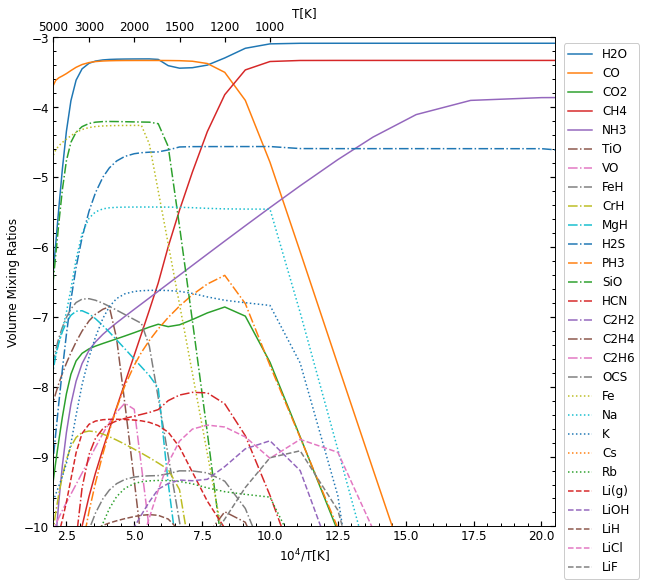

In [14]:
output_name="Viccher_Chemistry_Table_Li-bearing-Molecules_0.1bar"
output_path="plots/"
data=Visser_chem[Visser_chem.P==np.log10(1E0)]#;print(data)
data_labels1=["H2O","CO","CO2","CH4","NH3"]
linestyle1=  ["-","-","-","-","-"]
data_labels2=["TiO","VO","FeH","CrH","MgH",'H2S','PH3',"SiO","HCN","C2H2","C2H4","C2H6","OCS"]
linestyle2=  ["-.","-.","-.","-.","-.","-.","-.","-.","-.","-.","-.","-.","-."]
data_labels3=["Fe","Na",'K','Cs','Rb']
linestyle3=  [":",":",':',':',':']
data_labels4=["Li(g)","LiOH","LiH","LiCl","LiF"]
linestyle4=  ["--","--","--","--","--"]
plot_label="P=1 bar"
X=1E4/data["T"] 
y_range=(-10,-3)

data_labels=data_labels1+data_labels2+data_labels3+data_labels4 #; print(np.shape(data_label))
linestyle=linestyle1+linestyle2+linestyle3+linestyle4 ; print(np.shape(linestyle))
Y=np.log10(data[data_labels])
plot_vissher(X,Y, data_labels,y_range,linestyle)

data_labels2=[data_labels1,data_labels2,data_labels3,data_labels4]
linestyle2=[linestyle1,linestyle2,linestyle3,linestyle4]
for i in range(0):
    Y=np.log10(data[data_labels2[i]])
    plot_vissher(X,Y, data_labels2[i],y_range,linestyle2[i])


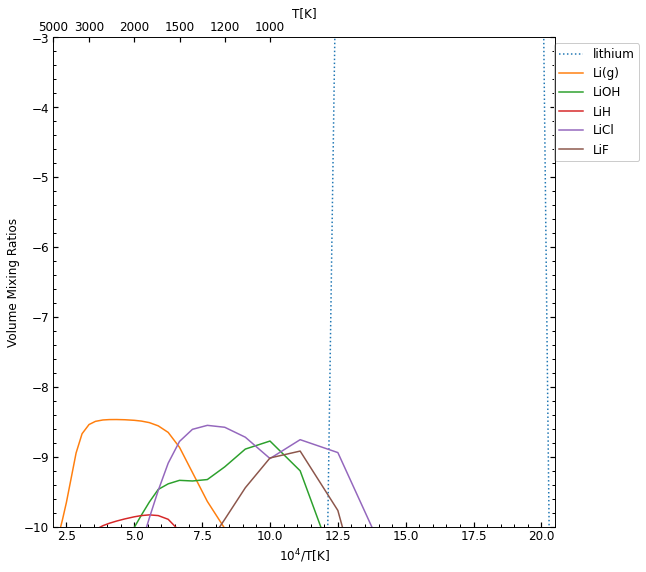

In [15]:
output_name="Viccher_Chemistry_Table_Li-bearing-Molecules_0.1bar"
output_path="plots/"
data=Visser_chem[Visser_chem.P==np.log10(1E0)]#;print(data)
data_labels=["lithium","Li(g)","LiOH","LiH","LiCl","LiF"];plot_label="P=1 bar"
linestyle=[":","-","-","-","-","-"]
X=1E4/data["T"] 
Y=np.log10(data[data_labels[:]])
x_lable="10$^4$/T[K]"
y_lable="log mole fraction"
#y_range=(-12,-8)
plot_vissher(X,Y, data_labels,y_range,linestyle)

In [16]:
def tricontour (X,Y,Z,lev,label):
    fig, ax = plt.subplots(figsize=(9,9))
    CS1 = ax.tricontour(T_,P_, Z[0],levels=lev,linestyles=['dotted','dashed','solid'],colors='k')
    CS2 = ax.tricontour(T_,P_, Z[1],levels=lev,linestyles=['dotted','dashed','solid'],colors='r')
    CS3 = ax.tricontour(T_,P_, Z[2],levels=lev,linestyles=['dotted','dashed','solid'],colors='g')
    CS4 = ax.tricontour(T_,P_, Z[3],levels=lev,linestyles=['dotted','dashed','solid'],colors='b')
    if len(Z)==5:
        CS5 = ax.tricontour(T_,P_, Z[4],levels=lev,linestyles=['dotted','dashed','solid'],colors='y')
        h5,_ = CS5.legend_elements()
    h1,_ = CS1.legend_elements()
    h2,_ = CS2.legend_elements()
    h3,_ = CS3.legend_elements()
    h4,_ = CS4.legend_elements()
    if len(Z)==5:
        ax.legend([h1[-1], h2[-1],h3[-1], h4[-1], h5[-1]], labels,loc='upper left')
    if len(Z)==4:
        ax.legend([h1[1], h2[1],h3[1], h4[1]], labels,loc='upper left',fontsize=12)
    ax.tick_params(direction='in',axis='y',length=5,width=1.2,labelsize=12,which='major')
    ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(direction='in',axis='x',length=5,width=1.2, labelsize=12, which="major")
    ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_ylabel("logP [bar]",fontsize=12)
    ax.set_xlabel("10$^4$/T [K]",fontsize=12)
    ax.set_ylim((3,-6))
    ax.set_xlim((2,10.5))
    ax2 = ax.twiny()
    new_tick_locations = np.array([2, 3.3333, 5, 6.6666,8.33333, 10])
    def tick_function(X):
        V = 1.0E4/(X)
        return ["%.0f" % z for z in V]
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.tick_params(direction='in',axis='y',length=5,width=1.2,labelsize=12,which='major')
    ax2.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
    ax2.yaxis.set_ticks_position('both')
    ax2.tick_params(direction='in',axis='x',length=5,width=1.2, labelsize=12, which="major")
    ax2.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax2.set_xlabel("T[K]",fontsize=12)
    #ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
    #ax2.legend(('LiF/Li(g)', 'LiOH/Li(g)',"LiH/Li(g)", "LiCl/Li(g)"),loc='upper left')


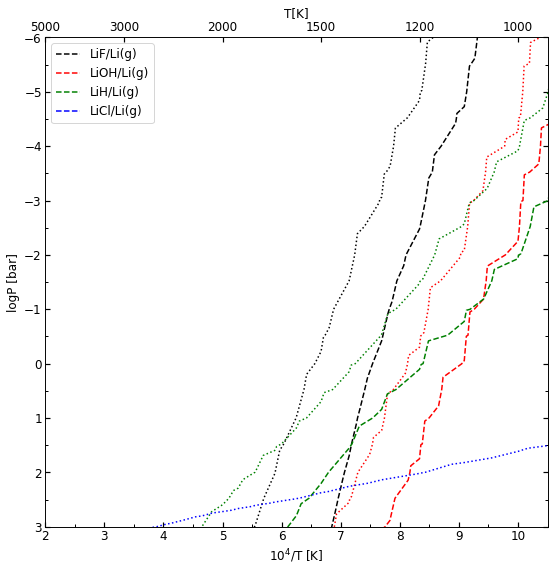

In [17]:
data=Visser_chem#[Visser_chem.P==np.log10(1E0)]#;print(data)
T_=1E4/data["T"] #; print("T_",np.shape(T_))
Li_g=data["Li(g)"] #; print("Li_g",np.shape(Li_g),Li_g)
P_=data.P#; print("P_",np.shape(P_))
LiCl=Visser_chem["LiCl"]
LiF=Visser_chem["LiF"]
LiH=Visser_chem["LiH"]
LiOH=Visser_chem["LiOH"]
Li_g=Visser_chem["Li(g)"]
lev=[1, 10]
labels=['LiF/Li(g)', 'LiOH/Li(g)',"LiH/Li(g)", "LiCl/Li(g)"]
tricontour(T_,P_,[LiCl/Li_g,LiF/Li_g,LiOH/Li_g,LiH/Li_g],lev,labels)

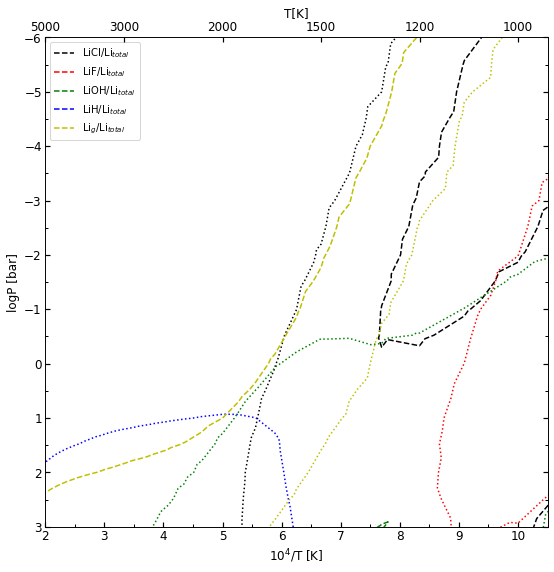

In [18]:
data=Visser_chem#[Visser_chem.P==np.log10(1E0)]#;print(data)
T_=1E4/data["T"] #; print("T_",np.shape(T_))
Li_g=data["Li(g)"] #; print("Li_g",np.shape(Li_g),Li_g)
P_=data.P#; print("P_",np.shape(P_))
LiCl=Visser_chem["LiCl"]
LiF=Visser_chem["LiF"]
LiH=Visser_chem["LiH"]
LiOH=Visser_chem["LiOH"]
Li_g=Visser_chem["Li(g)"]
Li_total=LiH+LiF+LiCl+LiOH+Li_g
lev=[.1,.8]
labels=["LiCl/Li$_{total}$","LiF/Li$_{total}$","LiOH/Li$_{total}$","LiH/Li$_{total}$","Li$_g$/Li$_{total}$"]
tricontour(T_,P_,[LiCl/Li_total,LiF/Li_total,LiOH/Li_total,LiH/Li_total,Li_g/Li_total],lev,labels)

Text(0.5, 0, 'T[K]')

<Figure size 648x648 with 0 Axes>

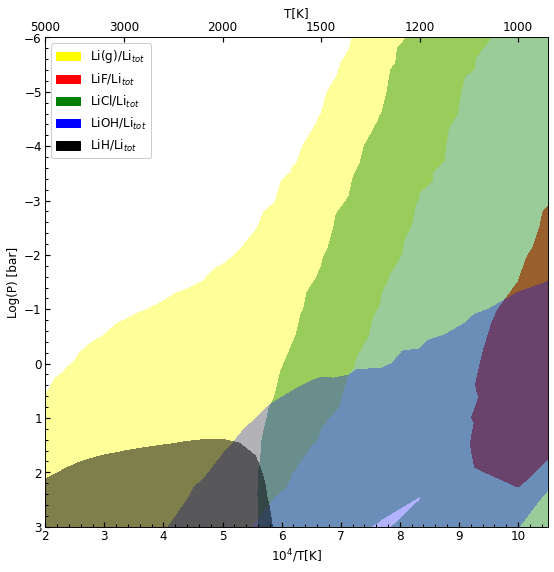

In [19]:
# Implementation of matplotlib function 
import matplotlib.pyplot as plt 
import matplotlib.tri as tri 
import numpy as np 
plt.figure(figsize=(9,9))    
data=Visser_chem#[Visser_chem.P==np.log10(1E0)]#;print(data)
T_=1E4/data["T"] #; print("T_",np.shape(T_))
Li_g=data["Li(g)"] #; print("Li_g",np.shape(Li_g),Li_g)
P_=data.P#; print("P_",np.shape(P_))
LiCl=Visser_chem["LiCl"]
LiF=Visser_chem["LiF"]
LiH=Visser_chem["LiH"]
LiOH=Visser_chem["LiOH"]
Li_g=Visser_chem["Li(g)"]
Li_total=LiH+LiF+LiCl+LiOH+Li_g
lev=[.15,.99]#.25,.35,.45,.55,.65,.75,.85,.99]

fig, ax = plt.subplots(figsize=(9,9))
labels=["Li(g)/Li$_{tot}$","LiF/Li$_{tot}$","LiCl/Li$_{tot}$","LiOH/Li$_{tot}$","LiH/Li$_{tot}$"]
ax.tricontourf(T_,P_,Li_g/Li_total,alpha=0.4,levels=lev, colors='yellow')
ax.tricontourf(T_,P_,LiF/Li_total,alpha=0.7,levels=lev,colors='red')
ax.tricontourf(T_,P_,LiCl/Li_total,alpha=0.4,levels=lev,colors='green')
ax.tricontourf(T_,P_,LiOH/Li_total,alpha=0.3,levels=lev,colors='blue')
ax.tricontourf(T_,P_,LiH/Li_total,alpha=0.5,levels=lev,colors='black')
ax.set_ylim((3,-6))
ax.set_xlim((2,10.5))
ax.set_xlabel("10$^4$/T[K]",fontsize=12)
ax.set_ylabel("Log(P) [bar]",fontsize=12)
ax.tick_params(direction='in',axis='y',length=5,width=1.2,labelsize=12,which='major')
ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
#plt.yaxis.set_ticks_position('both')
ax.tick_params(direction='in',axis='x',length=5,width=1.2, labelsize=12, which="major")
ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))


yy=plt.gca().add_patch(plt.Rectangle((2.2, -5), 1, -0.2, color = "yellow"))
rr=plt.gca().add_patch(plt.Rectangle((2.2, -5), 1, -0.2, color = "red"))
gg=plt.gca().add_patch(plt.Rectangle((2.2, -5), 1, -0.2, color = "green"))
bb=plt.gca().add_patch(plt.Rectangle((2.2, -5), 1, -0.2, color = "blue"))
kk=plt.gca().add_patch(plt.Rectangle((2.2, -5), 1, -0.2, color = "black"))
plt.legend([yy,rr,gg,bb,kk],labels,loc="upper left",fontsize=12,framealpha=1)

ax2 = ax.twiny()
new_tick_locations = np.array([2, 3.3333, 5, 6.6666,8.33333, 10])
def tick_function(X):
    V = 1.0E4/(X)
    return ["%.0f" % z for z in V]
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.tick_params(direction='in',axis='x',length=5,width=1.2, labelsize=12, which="major")
ax2.set_xlabel("T[K]",fontsize=12)


Text(0, 0.5, 'T[K]')

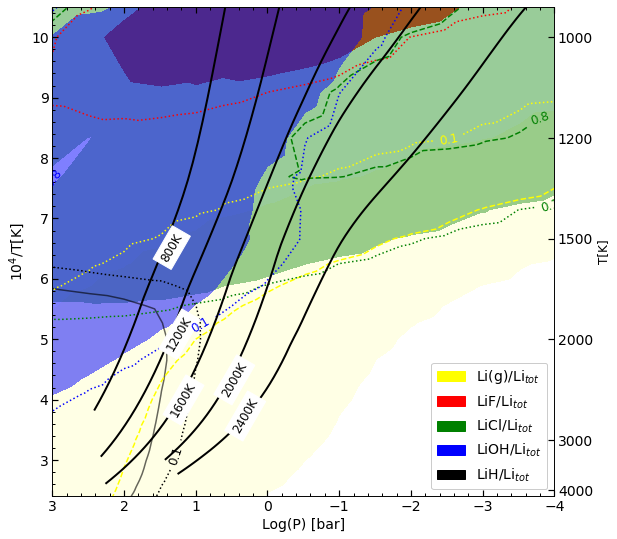

In [21]:
fig, ax = plt.subplots(figsize=(9,9))
CB_color= ['#377eb8', '#ff7f00', '#4daf4a', '#a65628', '#984ea3', '#e41a1c', '#dede00', "#D35FB7"]

Cols_names=["LVL","P","T","MU","H2","HE","CH4","CO","CO2","NH3","N2","H2O","TiO","VO","FeH","H2S"]
T=[800,1200,1600,2000,2400]
g=[1000]#,3160]#[100,1000,17,178,1780,31,316,3160,56,562]
for i in range(len(T)):
    sonora_path_lowg="/Users/egharibn/picaso/docs/Sonora/t"+str(T[i])+"g"+str(g[0])+"nc_m0.0.cmp"
    Sonora=pd.read_csv(sonora_path_lowg,names=Cols_names,skiprows=1,delim_whitespace=True)
    Y=1E4/Sonora["T"] 
    X=np.log10(Sonora["P"])
    TT=str(T[i])+"K"
    plt.text(X[77],Y[77],TT,fontsize=12,alpha=1,rotation=60,backgroundcolor="white")
    ax.plot(X,Y,"k-",lw=2)
        
data=Visser_chem#[Visser_chem.P==np.log10(1E0)]#;print(data)
T_=1E4/data["T"] #; print("T_",np.shape(T_))
Li_g=data["Li(g)"] #; print("Li_g",np.shape(Li_g),Li_g)
P_=data.P#; print("P_",np.shape(P_))
LiCl=Visser_chem["LiCl"];LiF=Visser_chem["LiF"]
LiH=Visser_chem["LiH"];LiOH=Visser_chem["LiOH"]
Li_g=Visser_chem["Li(g)"]
Li_total=LiH+LiF+LiCl+LiOH+Li_g
lev=[.15,.99]#.25,.35,.45,.55,.65,.75,.85,.99]

labels=["Li(g)/Li$_{tot}$","LiF/Li$_{tot}$","LiCl/Li$_{tot}$","LiOH/Li$_{tot}$","LiH/Li$_{tot}$"]
Y=T_;X=P_
ax.set_xlim((3,-4))
ax.set_ylim((2.4,10.5))
ax.tricontourf(X,Y,Li_g/Li_total,alpha=0.1,levels=lev, colors='yellow')
ax.tricontourf(X,Y,LiF/Li_total,alpha=0.8,levels=lev,colors='red')
ax.tricontourf(X,Y,LiCl/Li_total,alpha=0.4,levels=lev,colors='green')
ax.tricontourf(X,Y,LiOH/Li_total,alpha=0.5,levels=lev,colors='blue')
ax.tricontour(X,Y,LiH/Li_total,alpha=0.6,levels=lev,colors='black')
lev=[.10,.80]#.25,.35,.45,.55,.65,.75,.85,.99]
CS=ax.tricontour(X,Y,Li_g/Li_total,alpha=1.0,levels=lev, linestyles=['dotted','dashed','solid'], colors='yellow')
ax.clabel(CS, inline=1, fontsize=12,fmt = '%2.1f')
CS=ax.tricontour(X,Y,LiF/Li_total,alpha=1.0,levels=lev, linestyles=['dotted','dashed','solid'],colors='red')
ax.clabel(CS, inline=1, fontsize=12,fmt = '%2.1f')
CS=ax.tricontour(X,Y,LiCl/Li_total,alpha=1,levels=lev, linestyles=['dotted','dashed','solid'],colors='green')
ax.clabel(CS, inline=1, fontsize=12,fmt = '%2.1f')
CS=ax.tricontour(X,Y,LiOH/Li_total,alpha=1,levels=lev, linestyles=['dotted','dashed','solid'],colors='blue')
ax.clabel(CS, inline=1, fontsize=12,fmt = '%2.1f')
CS=ax.tricontour(X,Y,LiH/Li_total,alpha=1.0,levels=lev, linestyles=['dotted','dashed','solid'],colors='black')
ax.clabel(CS, inline=1, fontsize=12,fmt = '%2.1f')

ax.set_ylabel("10$^4$/T[K]",fontsize=14)
ax.set_xlabel("Log(P) [bar]",fontsize=14)
ax.tick_params(direction='in',axis='both',length=6,width=1.2,labelsize=14,which='major')
ax.tick_params(direction='in',axis='both',length=3,width=1,labelsize=14,which='minor')
ax.xaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    #ax.set_xscale('log')
    #ax.set_yscale('log')

yy=plt.gca().add_patch(plt.Rectangle((2.2, -5), 1, -0.2, color = "yellow"))
rr=plt.gca().add_patch(plt.Rectangle((2.2, -5), 1, -0.2, color = "red"))
gg=plt.gca().add_patch(plt.Rectangle((2.2, -5), 1, -0.2, color = "green"))
bb=plt.gca().add_patch(plt.Rectangle((2.2, -5), 1, -0.2, color = "blue"))
kk=plt.gca().add_patch(plt.Rectangle((2.2, -5), 1, -0.2, color = "black"))
plt.legend([yy,rr,gg,bb,kk],labels,loc="lower right",fontsize=14,framealpha=1)

ax2 = ax.twinx()
new_tick_locations = np.array([2.5, 3.3333, 5, 6.6666,8.33333, 10])
def tick_function(Y):
    V = 1.0E4/(Y)
    return ["%.0f" % z for z in V]
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(new_tick_locations)
ax2.set_yticklabels(tick_function(new_tick_locations))
ax2.tick_params(direction='in',axis='y',length=6,width=1.2, labelsize=14, which="major")
ax2.set_ylabel("T[K]",fontsize=12,alpha=1)

## Plot Sonora T P profiles for different surface gravities
Link: https://zenodo.org/record/1309035

# Marley Sonora/Bobcat Grid Models
Link: https://zenodo.org/record/2628068#.XwZaSS2ZN3k

In [19]:
path_Bob="/Users/egharibn/picaso/reference/Sonora_Bobcat_Tables/evolution_tables/evo_tables+0.0/" #"201507_grid75_feh_000_co_100_hiP_Li.txt"

#  Age
path_Bob_age=path_Bob+"nc+0.0_co1.0_age"
name_Bob_age=[ "age(Gyr)","M/Msun","log_L/Lsun","Teff","log_g","R/Rsun"]
Bobcat_age=pd.read_csv(path_Bob_age,names=name_Bob_age,skiprows=2,delim_whitespace=True,dtype= np.float64)
Bobcat_age=Bobcat_age[Bobcat_age['R/Rsun'].notnull()]
#print(Bobcat_age["age(Gyr)"])


Teff=Bobcat_age["Teff"]#.iloc[0:18]    # T_eff [K]
M=1047.577*Bobcat_age["M/Msun"]       # in M_Jupiter
t=1.0E9*Bobcat_age["age(Gyr)"]#.iloc[0:14]#;print(np.shape(t))    # surface gravity in [m.s^-1] equalent to log(g)=2-3.7







result=np.zeros((len(t),len(Teff)));print("===",np.shape(result))
for i in range(len(t)):
    for j in range(len(Teff)):
        XX=Bobcat_age[ (Bobcat_age["age(Gyr)"]==Bobcat_age["age(Gyr)"].iloc[i]) & (Bobcat_age["Teff"]==Bobcat_age["Teff"].iloc[j])]
        print (XX,XX["M/Msun"].iloc[0])
        result[i,j]=XX["M/Msun"].iloc[0];print(result[j,i])

print("=====HHHH",np.shape(result),result)
Teff, t = np.meshgrid(Teff,t);print("t,Teff",np.shape(t),np.shape(Teff))
fig, ax = plt.subplots()
CS = ax.contour(t, Teff, result)
ax.clabel(CS, inline=1, fontsize=10,fmt = '%2.0f') 
ax.set_xlabel("T$_{eff}$[K]",fontsize=12)
ax.set_ylabel("log(g) [m.s$^{-2}$]",fontsize=12)
ax.tick_params(direction='in',axis='y',length=4,width=1.5,labelsize=12,which='major')
ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_xscale('log')
ax.tick_params(direction='in',axis='x',length=4,width=1.5, labelsize=12, which="major")
ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
#ax.set_xlim((1E7,5E7))
#ax.set_ylim((1500,1550))

=== (1339, 1339)
   age(Gyr)  M/Msun  log_L/Lsun   Teff  log_g  R/Rsun
0     0.001  0.0005      -5.361  631.0  2.654  0.1743 0.0005
0.0005
   age(Gyr)  M/Msun  log_L/Lsun   Teff  log_g  R/Rsun
1     0.001   0.001      -4.757  930.0  3.024  0.1609 0.001
0.0
   age(Gyr)  M/Msun  log_L/Lsun    Teff  log_g  R/Rsun
2     0.001  0.0015      -4.403  1135.0  3.192  0.1625 0.0015
0.0
   age(Gyr)  M/Msun  log_L/Lsun    Teff  log_g  R/Rsun
3     0.001   0.002      -4.143  1302.0  3.296  0.1664 0.002
0.0
   age(Gyr)  M/Msun  log_L/Lsun    Teff  log_g  R/Rsun
4     0.001  0.0025      -3.926  1452.0  3.365  0.1719 0.0025
0.0
   age(Gyr)  M/Msun  log_L/Lsun    Teff  log_g  R/Rsun
5     0.001   0.003      -3.748  1580.0  3.413  0.1781 0.003
0.0
   age(Gyr)  M/Msun  log_L/Lsun    Teff  log_g  R/Rsun
6     0.001  0.0035      -3.604  1688.0   3.45  0.1843 0.0035
0.0
   age(Gyr)  M/Msun  log_L/Lsun    Teff  log_g  R/Rsun
7     0.001   0.004       -3.48  1785.0  3.481  0.1903 0.004
0.0
   age(Gyr)  M/Msun 

IndexError: single positional indexer is out-of-bounds

## Table name:  nc+0.0_co1.0_age

0        0.001
1        0.001
2        0.001
3        0.001
4        0.001
         ...  
1361    10.000
1362    10.000
1363    10.000
1364    10.000
1365    10.000
Name: age(Gyr), Length: 1339, dtype: float64


Text(0.5, 1.0, 'Bobcat Table Name: nc+0.0_co1.0_age')

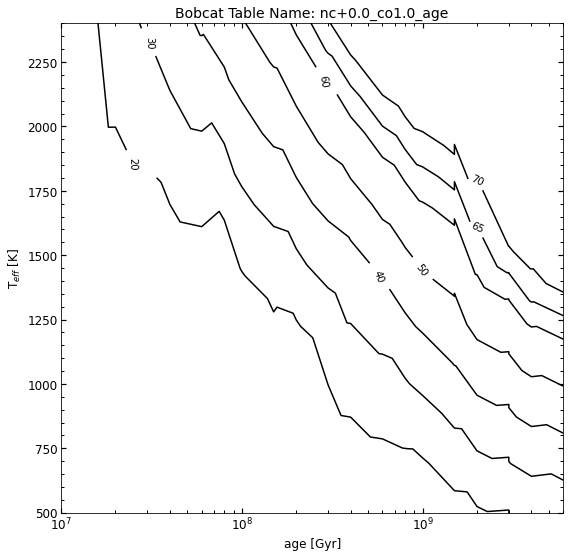

In [21]:
path_Bob="/Users/egharibn/picaso/reference/Sonora_Bobcat_Tables/evolution_tables/evo_tables+0.0/" #"201507_grid75_feh_000_co_100_hiP_Li.txt"

#  Age
path_Bob_age=path_Bob+"nc+0.0_co1.0_age"
name_Bob_age=[ "age(Gyr)","M/Msun","log_L/Lsun","Teff","log_g","R/Rsun"]
Bobcat_age=pd.read_csv(path_Bob_age,names=name_Bob_age,skiprows=2,delim_whitespace=True,dtype= np.float64)
Bobcat_age=Bobcat_age[Bobcat_age['R/Rsun'].notnull()]
print(Bobcat_age["age(Gyr)"])


fig, ax = plt.subplots(figsize=(9,9))
ax.set_xlim((1E7,1E10))
lev=[20,30,40,50,60,65,70]
X="age(Gyr)";Y="Teff";Z="M/Msun"
CS = ax.tricontour(1E9*Bobcat_age[X],Bobcat_age[Y],1047.577*Bobcat_age[Z],levels=lev,colors="k")
ax.clabel(CS, CS.levels, inline=True, fmt='%2.0f', fontsize=10)
ax.set_xlabel("age [Gyr]",fontsize=12)#;ax.set_xlim((0.1,2))
ax.set_ylabel("T$_{eff}$ [K]",fontsize=12)
ax.tick_params(direction='in',axis='y',length=5,width=1.2,labelsize=12,which='major')
ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction='in',axis='x',length=5,width=1.2, labelsize=12, which="major")
ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
#ax.set_yscale('log')
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
#ax.set_xticks([0.1,1,2]);
ax.set_xlim((1E7,6E9))
ax.set_ylim((500,2400))
ax.set_xscale('log')
ax.set_title("Bobcat Table Name: nc+0.0_co1.0_age",fontsize=14)

## Table name:  nc+0.0_co1.0_mass

Text(0.5, 1.0, 'Bobcat Table Name: nc+0.0_co1.0_mass')

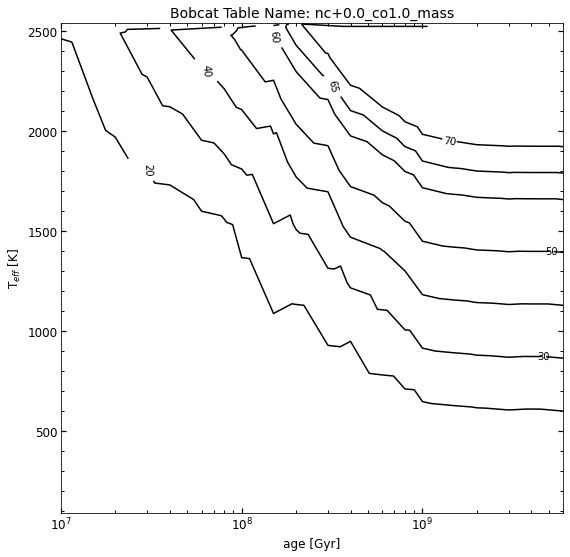

In [87]:
path_Bob="/Users/egharibn/picaso/reference/Sonora_Bobcat_Tables/evolution_tables/evo_tables+0.0/" #"201507_grid75_feh_000_co_100_hiP_Li.txt"
from scipy.ndimage.filters import gaussian_filter
import scipy.ndimage
#  Mass
path_Bob_mass=path_Bob+"nc+0.0_co1.0_mass"
name_Bob_mass=[ "M/Msun","age(Gyr)","log_L/Lsun","Teff","log_g","R/Rsun"]
Bobcat_mass=pd.read_csv(path_Bob_mass,names=name_Bob_mass,skiprows=1,delim_whitespace=True)
Bobcat_mass=Bobcat_mass[Bobcat_mass['R/Rsun'].notnull()]
#print(Bobcat_mass)


fig, ax = plt.subplots(figsize=(9,9))
ax.set_xlim((1E7,6E9))
#ax.set_ylim((500,2400))
lev=[20,30,40,50,60,65,70]
X="age(Gyr)";Y="Teff";Z="M/Msun"
CS = ax.tricontour(1E9*Bobcat_mass[X],Bobcat_mass[Y],1047.577*Bobcat_mass[Z],levels=lev,colors="k")
ax.clabel(CS, CS.levels, inline=True, fmt='%2.0f', fontsize=10)
ax.set_xlabel("age [Gyr]",fontsize=12)#;ax.set_xlim((0.1,2))
ax.set_ylabel("T$_{eff}$ [K]",fontsize=12)
ax.tick_params(direction='in',axis='y',length=5,width=1.2,labelsize=12,which='major')
ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction='in',axis='x',length=5,width=1.2, labelsize=12, which="major")
ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xscale('log')
#ax.set_xticks([0.1,1,2]);
#ax.set_xlim((0.1,5))
ax.set_title("Bobcat Table Name: nc+0.0_co1.0_mass",fontsize=14)

Text(0.5, 1.0, 'File Name: nc+0.0_co1.0_mass')

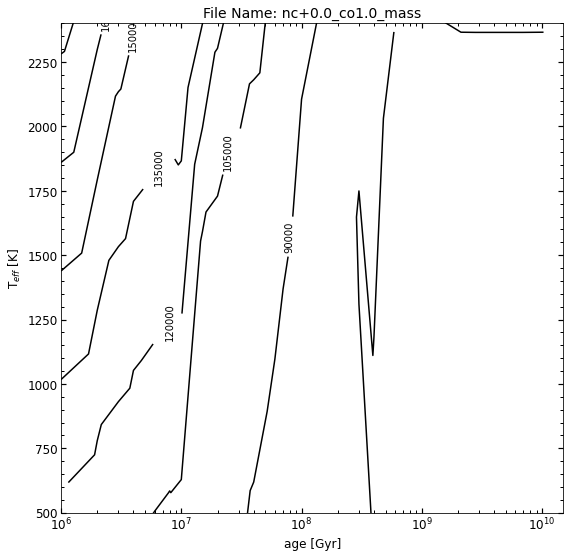

In [23]:
path_Bob="/Users/egharibn/picaso/reference/Sonora_Bobcat_Tables/evolution_tables/evo_tables+0.0/" #"201507_grid75_feh_000_co_100_hiP_Li.txt"

#  Mass
path_Bob_mass=path_Bob+"nc+0.0_co1.0_mass"
name_Bob_mass=[ "M/Msun","age(Gyr)","log_L/Lsun","Teff","log_g","R/Rsun"]
Bobcat_mass=pd.read_csv(path_Bob_mass,names=name_Bob_mass,skiprows=1,delim_whitespace=True)
Bobcat_mass=Bobcat_mass[Bobcat_mass['R/Rsun'].notnull()]
#print(Bobcat_mass)


fig, ax = plt.subplots(figsize=(9,9))
#ax.set_xlim((1E7,1E10))
ax.set_ylim((500,2400))
X="age(Gyr)";Y="Teff";Z="R/Rsun"
CS = ax.tricontour(1E9*Bobcat_mass[X],Bobcat_mass[Y],695700*Bobcat_mass[Z],colors="k")
ax.clabel(CS, inline=True, fmt='%2.0f', fontsize=10)
ax.set_xlabel("age [Gyr]",fontsize=12)#;ax.set_xlim((0.1,2))
ax.set_ylabel("T$_{eff}$ [K]",fontsize=12)
ax.tick_params(direction='in',axis='y',length=5,width=1.2,labelsize=12,which='major')
ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction='in',axis='x',length=5,width=1.2, labelsize=12, which="major")
ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xscale('log')
#ax.set_xticks([0.1,1,2]);
#ax.set_xlim((0.1,5))
ax.set_title("File Name: nc+0.0_co1.0_mass",fontsize=14)

## Table Name: nc+0.0_co1.0_mass_age

        Teff   log_g   Mass  Radius  log_L  log_age
0     0.0005   0.001 -5.361   631.0  2.654   0.1743
1     0.0005   0.002 -5.702   538.0  2.716   0.1622
2     0.0005   0.003 -5.912   485.0  2.748   0.1565
3     0.0005   0.004 -6.053   453.0  2.768   0.1528
4     0.0005   0.006 -6.216   419.0  2.796   0.1481
...      ...     ...    ...     ...    ...      ...
1483  0.0800   4.000 -3.608  2286.0  5.341   0.1000
1484  0.0800   6.000 -3.609  2286.0  5.341   0.1000
1485  0.0800   8.000 -3.609  2286.0  5.341   0.1000
1486  0.0800  10.000 -3.609  2286.0  5.341   0.1000
1487  0.0800  15.000 -3.609  2286.0  5.341   0.0999

[1422 rows x 6 columns]


Text(0.5, 1.0, 'File Name: nc+0.0_co1.0_mass_age')

/usr/local/anaconda3/envs/picaso2/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


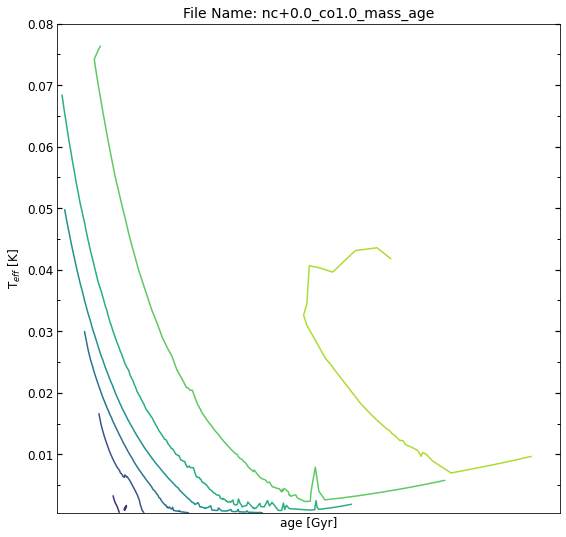

In [24]:
path_Bob="/Users/egharibn/picaso/reference/Sonora_Bobcat_Tables/evolution_tables/evo_tables+0.0/" #"201507_grid75_feh_000_co_100_hiP_Li.txt"
#  Mass
path_Bob_mass_age=path_Bob+"nc+0.0_co1.0_mass_age"
name_Bob_mass_age=["Teff","log_g","Mass","Radius","log_L","log_age"]
Bobcat_mass_age=pd.read_csv(path_Bob_mass,names=name_Bob_mass_age,skiprows=2,delim_whitespace=True)
Bobcat_mass_age=Bobcat_mass_age[Bobcat_mass_age['Mass'].notnull()]
print(Bobcat_mass_age)


fig, ax = plt.subplots(figsize=(9,9))
#levs=[6E4,8E4,10E4]
X="log_age";Y="Teff";Z="Mass"
CS = ax.tricontour(10**Bobcat_mass_age[X],Bobcat_mass_age[Y],Bobcat_mass_age[Z])
#ax.clabel(CS, CS.levels, inline=True, fmt='%2.0f', fontsize=10)
#ax.clabel(CS, inline=True, fontsize=10,fmt = '%2.0f')
ax.set_xlabel("age [Gyr]",fontsize=12)#;ax.set_xlim((0.1,2))
ax.set_ylabel("T$_{eff}$ [K]",fontsize=12)
ax.tick_params(direction='in',axis='y',length=5,width=1.2,labelsize=12,which='major')
ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction='in',axis='x',length=5,width=1.2, labelsize=12, which="major")
ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")
ax.set_xscale('log')
#ax.set_yscale('log')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
#ax.set_xticks([0.1,1,2]);
#ax.set_xlim((1E6,1E10))
#ax.set_ylim((200,2000))
ax.set_title("File Name: nc+0.0_co1.0_mass_age",fontsize=14)

In [37]:
def plot_Sonora(T,g):
    fig=plt.figure(figsize=(4, 5))
    gs = gridspec.GridSpec(ncols=1, nrows=1)
    ax=plt.subplot(gs[0])
    plt.minorticks_on()
    ax.tick_params(direction='in',axis='y',length=4,width=1.5,labelsize=12,which='major')
    ax.tick_params(direction='in',axis='y',length=3,width=1,labelsize=10,which='minor')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(direction='in',axis='x',length=4,width=1.5, labelsize=12, which="major")
    ax.tick_params(direction='in',axis='x',length=3,width=1, labelsize=10, which="minor")    #ax11.set_yscale('log')
    #ax11.set_xscale('log')
    #ax11.set_xticks([2, 4, 6, 8, 8, 10, 12, 14])
    #ax11.set_yticks([1E-30, 1E-24, 1E-22, 1E-20])
    CB_color= ['#377eb8', '#ff7f00', '#4daf4a', '#a65628', '#984ea3', '#e41a1c', '#dede00', "#D35FB7"]
    #
    Cols_names=["LVL","P","T","MU","H2","HE","CH4","CO","CO2","NH3","N2","H2O","TiO","VO","FeH","H2S"]
    for i in range(len(g)):
        sonora_path_lowg="/Users/egharibn/picaso/docs/Sonora/t"+str(T)+"g"+str(g[i])+"nc_m0.0.cmp"
        Sonora=pd.read_csv(sonora_path_lowg,names=Cols_names,skiprows=1,delim_whitespace=True)
        Y=Sonora["T"] 
        X=np.log10(Sonora["P"])
        ax.plot(X,Y,"-")
    #output_name="Marley_grid_models_"+str(T)+"K"
    #output_path="plots/"
    #data=Sonora[Visser_chem.P==np.log10(1E2)]#;print(data)
    #data_labels=["g 17","g 1000"];plot_label="P=100 bar"
    #plt.plot(Li_LiF[:,0],Li_LiF[:,1],"o")

#ax.set_xscale('log')
#ax.set_yscale('log')
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    y_lable="T[K]"
    x_lable="log P[bar]"
    for axis in [ax.xaxis]:
        formatter = ScalarFormatter()
        formatter.set_scientific(False)
        axis.set_major_formatter(formatter)
    ax.set_ylabel(y_lable,fontsize=12)
    ax.set_xlabel(x_lable,fontsize=12)
    #ax11.text(3,-8.3,plot_label,fontsize=11,fontweight='bold')
    #ax.legend(data_labels,frameon=False,loc="upper right", ncol=1,fontsize=9,labelspacing=.1)
    ax.set_xlim((max(X),min(X)))
    #ax11.set_ylim((-12,-7.9))
    plt.subplots_adjust(left=.22, bottom=.18, right=.99, top=.97, wspace=None, hspace=None)
    fig.savefig(output_path+output_name+".pdf")

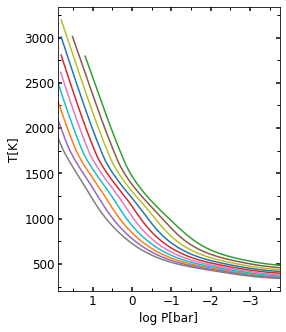

In [35]:
g=[100,1000,17,178,1780,31,316,3160,56,562]
plot_Sonora(1000,g)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
path_Bob="/Users/egharibn/picaso/reference/Sonora_Bobcat_Tables/evolution_tables/evo_tables+0.0/" #"201507_grid75_feh_000_co_100_hiP_Li.txt"

#  Age
path_Bob_age=path_Bob+"nc+0.0_co1.0_age"
name_Bob_age=[ "age(Gyr)","M/Msun","log_L/Lsun","Teff","log_g","R/Rsun"]
Bobcat_age=pd.read_csv(path_Bob_age,names=name_Bob_age,skiprows=2,delim_whitespace=True,dtype= np.float64)
Bobcat_age=Bobcat_age[Bobcat_age['R/Rsun'].notnull()]
#print(Bobcat_age["age(Gyr)"])


y=Bobcat_age["Teff"]#.iloc[0:18]    # T_eff [K]
z=1047.577*Bobcat_age["M/Msun"]       # in M_Jupiter
x=1.0E9*Bobcat_age["age(Gyr)"]#.iloc[0:14]#;print(np.shape(t))    # surface gravity in [m.s^-1] equalent to log(g)=2-3.7


npts = 200
ngridx = 100
ngridy = 5000


fig, ax1 = plt.subplots(figsize=(9,9))

xi = np.linspace(1E7, 1E10, ngridx)
yi = np.linspace(200, 2500, ngridy)

# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

# Note that scipy.interpolate provides means to interpolate data on a grid
# as well. The following would be an alternative to the four lines above:
from scipy.interpolate import griddata
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')

ax1.set(xlim=(1E8, 8E9), ylim=(300, 2500))
ax1.contour(xi, yi, zi, levels=[20,30,40,50,60,65], linewidths=0.5, colors='k')
cntr1 = ax1.contour(xi, yi, zi, levels=[20,30,40,50,60,65], cmap="RdBu_r")
ax1.clabel(cntr1, cntr1.levels, inline=True, fmt='%2.0f', fontsize=10)

#fig.colorbar(cntr1, ax=ax1)
#ax1.plot(x, y, 'ko', ms=3)
#ax1.set_title('grid and contour (%d points, %d grid points)' %
#              (npts, ngridx * ngridy))

